In [18]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [19]:
import pandas as pd
import numpy as np
import librosa   #for audio processing
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import numpy as np
from scipy.io import wavfile #for audio processing
import warnings
warnings.filterwarnings("ignore")

In [20]:
import os
os.chdir("/content/drive/My Drive/speech-data/Audios/AMHARIC")
os.listdir()

['README.md', 'data', 'kaldi-script', 'lang', 'lm']

In [21]:
def tran_loader(filename):
  name_to_text = {}
  with open (filename, encoding="utf-8")as f:
    f.readline()
    for line in f:
      name=line.split("</s>")[1]
      name=name.replace('(', '')
      name=name.replace(')', '')
      name=name.replace('\n','')
      name=name.replace(' ','')
      text=line.split("</s>")[0]
      text=text.replace("<s>","")
      name_to_text[name]=text
    return name_to_text

In [22]:
transcription=tran_loader("/content/drive/MyDrive/speech-data/Audios/AMHARIC/data/train/trsTrain.txt")

In [23]:
def meta_data(trans, path ):
  target=[]
  features=[]
  filenames=[]
  duration_of_recordings=[]
  for k in trans:
    filename=path+k +".wav"
    filenames.append(filename)
    audio, fs = librosa.load(filename, sr=None)
    duration_of_recordings.append(float(len(audio)/fs))
   
    lable = trans[k]
    target.append(lable)
  return filenames, target,duration_of_recordings


In [24]:
# filenames, target,duration_of_recordings= meta_data(transcription,'valid/')

In [ ]:
# !pip install librosa
# !pip install python_speech_features

In [26]:
from itertools import cycle
sns.set_theme(style='white', palette=None)
color_pal = plt.rcParams['axes.prop_cycle'].by_key()['color']
color_cycle = cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

In [27]:
# !git clone https://github.com/getalp/ALFFA_PUBLIC.git

In [28]:
# !du -sh ALFFA_PUBLIC/

In [29]:
# !du -sh ALFFA_PUBLIC/ASR/*

In [30]:
# !cp -r ALFFA_PUBLIC/ASR/AMHARIC ALFFA_PUBLIC/ASR/SWAHILI drive/MyDrive/speech-data/Swahili

In [31]:
# !du -sh drive/MyDrive/speech-data/Swahili/SWAHILI/data*

### loading data with librosa

In [32]:
audios = glob('/content/drive/MyDrive/speech-data/Audios/AMHARIC/data/train/*/*.wav')

loading the first audio

In [50]:
samples, sr = librosa.load(audios[0])

In [51]:
samples

array([-0.12482329, -0.14234683, -0.12056861, ..., -0.1422647 ,
       -0.12749854,  0.        ], dtype=float32)

In [35]:
sr

22050

displaying one of the audios

In [52]:
ipd.Audio(samples,rate=sr)

# Visualizing Audio

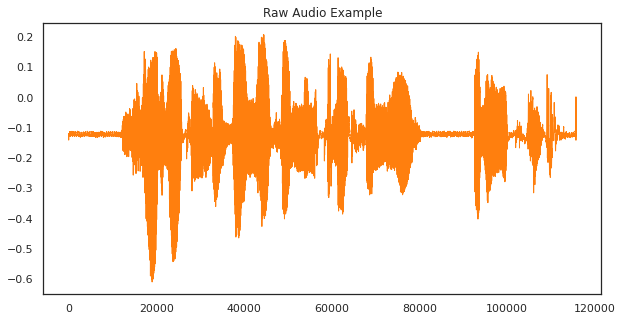

In [53]:
# ploting the discrete samples in this case the sample is the x value
pd.Series(samples).plot(figsize=(10,5),
                  lw=1,
                  title='Raw Audio Example',
                  color=color_pal[1])

plot of the sample audio file itself, and it shows at the beginning of the audio it was silent after some time it the frequecy of audio start increasing

(array([3.4000e+01, 1.0900e+02, 4.2600e+02, 1.5850e+03, 9.7060e+03,
        5.5104e+04, 3.7873e+04, 8.2640e+03, 2.2060e+03, 4.1200e+02]),
 array([-0.6114245 , -0.52973104, -0.4480375 , -0.366344  , -0.2846505 ,
        -0.202957  , -0.12126351, -0.03957001,  0.04212349,  0.12381698,
         0.20551048], dtype=float32),
 <a list of 10 Patch objects>)

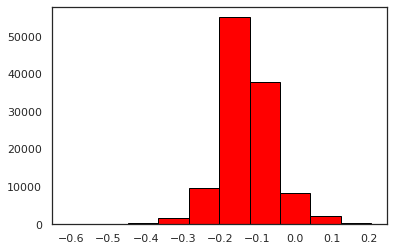

In [54]:
plt.hist(samples, color='red', edgecolor='black')

This historgram plot of the audio file shows also at the beginning and end the audio goes silent 

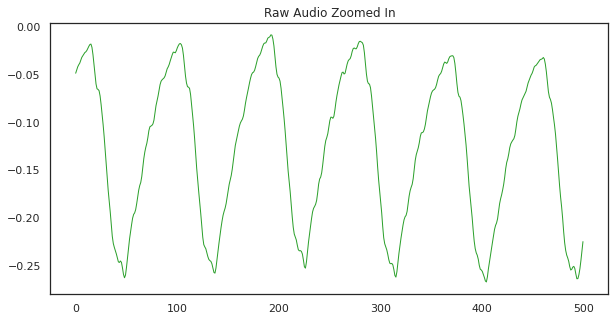

In [55]:
pd.Series(samples[30000:30500]).plot(figsize=(10,5),
                               lw=1,
                               title='Raw Audio Zoomed In',
                               color = color_pal[2])
plt.show()

This plot shows the audio[0] file zoomed plot to see more clearly

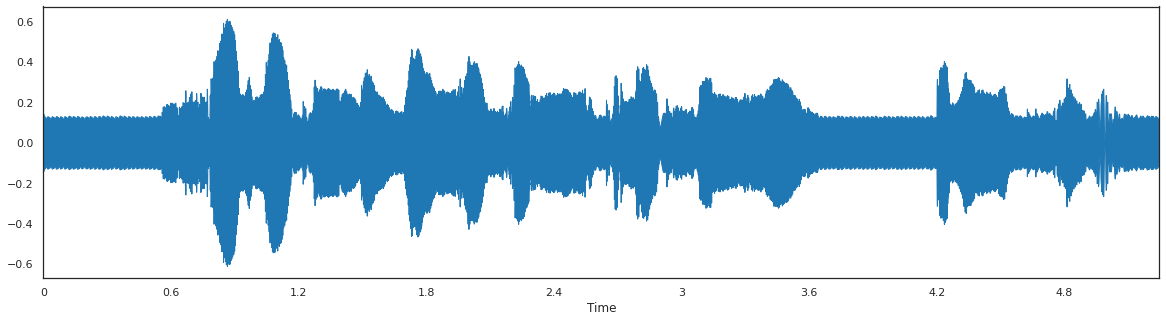

In [56]:
import librosa.display
#Plot the signal:
plt.figure(figsize=(20, 5))
librosa.display.waveplot(samples, sr=sr)

The graph indicated the sampling frequency taken over some fixed amount of time

# Spectogram

A spectrogram is a visual way of representing the signal strength, or “loudness”, of a signal over time at various frequencies present in a particular waveform.

In [58]:
from numpy.lib.stride_tricks import as_strided
def spectrogram(samples, fft_length=256, sample_rate=2, hop_length=128):
    """
    Compute the spectrogram for a real signal.
    The parameters follow the naming convention of
    matplotlib.mlab.specgram

    Args:
        samples (1D array): input audio signal
        fft_length (int): number of elements in fft window
        sample_rate (scalar): sample rate
        hop_length (int): hop length (relative offset between neighboring
            fft windows).

    Returns:
        x (2D array): spectrogram [frequency x time]
        freq (1D array): frequency of each row in x

    Note:
        This is a truncating computation e.g. if fft_length=10,
        hop_length=5 and the signal has 23 elements, then the
        last 3 elements will be truncated.
    """
    assert not np.iscomplexobj(samples), "Must not pass in complex numbers"

    window = np.hanning(fft_length)[:, None]
    window_norm = np.sum(window**2)

    # The scaling below follows the convention of
    # matplotlib.mlab.specgram which is the same as
    # matlabs specgram.
    scale = window_norm * sample_rate

    trunc = (len(samples) - fft_length) % hop_length
    x = samples[:len(samples) - trunc]

    # "stride trick" reshape to include overlap
    nshape = (fft_length, (len(x) - fft_length) // hop_length + 1)
    nstrides = (x.strides[0], x.strides[0] * hop_length)
    x = as_strided(x, shape=nshape, strides=nstrides)

    # window stride sanity check
    assert np.all(x[:, 1] == samples[hop_length:(hop_length + fft_length)])

    # broadcast window, compute fft over columns and square mod
    x = np.fft.rfft(x * window, axis=0)
    x = np.absolute(x)**2

    # scale, 2.0 for everything except dc and fft_length/2
    x[1:-1, :] *= (2.0 / scale)
    x[(0, -1), :] /= scale

    freqs = float(sample_rate) / fft_length * np.arange(x.shape[0])

    return x, freqs

In [59]:
spe_samples,frequency=spectrogram(samples)

In [62]:
frequency

array([0.       , 0.0078125, 0.015625 , 0.0234375, 0.03125  , 0.0390625,
       0.046875 , 0.0546875, 0.0625   , 0.0703125, 0.078125 , 0.0859375,
       0.09375  , 0.1015625, 0.109375 , 0.1171875, 0.125    , 0.1328125,
       0.140625 , 0.1484375, 0.15625  , 0.1640625, 0.171875 , 0.1796875,
       0.1875   , 0.1953125, 0.203125 , 0.2109375, 0.21875  , 0.2265625,
       0.234375 , 0.2421875, 0.25     , 0.2578125, 0.265625 , 0.2734375,
       0.28125  , 0.2890625, 0.296875 , 0.3046875, 0.3125   , 0.3203125,
       0.328125 , 0.3359375, 0.34375  , 0.3515625, 0.359375 , 0.3671875,
       0.375    , 0.3828125, 0.390625 , 0.3984375, 0.40625  , 0.4140625,
       0.421875 , 0.4296875, 0.4375   , 0.4453125, 0.453125 , 0.4609375,
       0.46875  , 0.4765625, 0.484375 , 0.4921875, 0.5      , 0.5078125,
       0.515625 , 0.5234375, 0.53125  , 0.5390625, 0.546875 , 0.5546875,
       0.5625   , 0.5703125, 0.578125 , 0.5859375, 0.59375  , 0.6015625,
       0.609375 , 0.6171875, 0.625    , 0.6328125, 

In [61]:
spe_samples

array([[1.37037782e+00, 1.20787437e+00, 1.28791509e+00, ...,
        1.39353393e+00, 1.29619979e+00, 1.13724826e+00],
       [6.98472576e-01, 5.95706466e-01, 6.60287618e-01, ...,
        7.15775307e-01, 6.71508884e-01, 5.44348600e-01],
       [2.17964617e-05, 3.73430980e-04, 3.25050359e-04, ...,
        8.60036368e-05, 1.51654355e-04, 2.83541317e-04],
       ...,
       [6.03603561e-14, 9.83142783e-16, 1.00256638e-15, ...,
        1.76809764e-15, 3.03936558e-15, 1.13116146e-14],
       [4.32423682e-14, 1.63906557e-15, 6.27468481e-16, ...,
        9.22554705e-16, 2.50900390e-16, 2.03666594e-15],
       [2.98312300e-14, 7.87025974e-16, 5.44268552e-16, ...,
        5.64749240e-16, 4.81483930e-16, 7.43441270e-15]])

In [63]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_spectrogram_feature(vis_spectrogram_feature):
    # plot the normalized spectrogram
    fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(111)
    im = ax.imshow(vis_spectrogram_feature, cmap=plt.cm.jet, aspect='auto')
    plt.title('Spectrogram')
    plt.ylabel('Time')
    plt.xlabel('Frequency')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    plt.show()

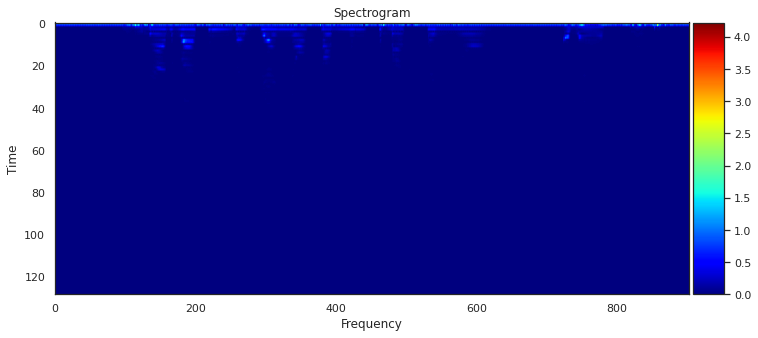

In [64]:
plot_spectrogram_feature(spe_samples)

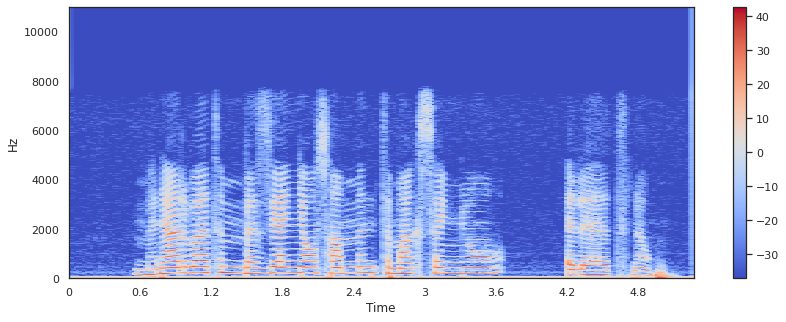

In [68]:
X = librosa.stft(samples)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.colorbar()
plt.show()

 The vertical axis shows frequencies (from 0 to 10kHz), and the horizontal axis shows the time of the clip.

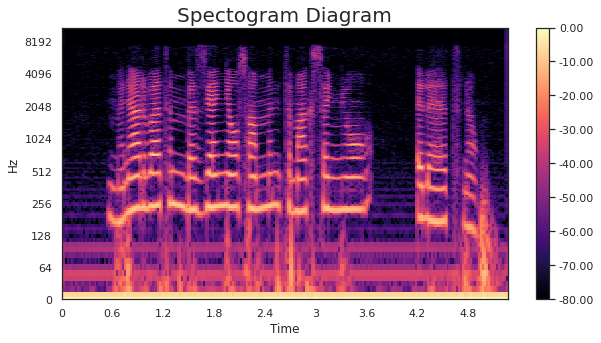

In [73]:
D = librosa.stft(samples)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
# plot the transformed audio data
fig,ax = plt.subplots(figsize=(10,5))
img = librosa.display.specshow(S_db,
                               x_axis='time',
                               y_axis='log',
                               ax=ax)
ax.set_title('Spectogram Diagram', fontsize=20)
fig.colorbar(img, ax=ax, format=f'%0.2f')
plt.show()

In this spectogram plot the maximum frequencies are extract out to show there sounding at different part of the audiop[0] file in decibel unit

# Data Augumentation

**Time Shifting**

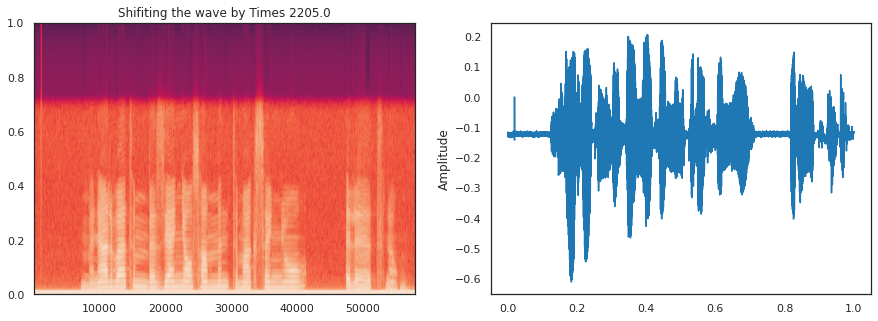

In [70]:
def plot_spec(data:np.array,sr:int) -> None:
  '''
  Function for plotting spectrogram along with amplitude wave graph
  '''
  
  fig, ax = plt.subplots(1,2,figsize=(15,5))
  ax[0].title.set_text(f'Shifiting the wave by Times {sr/10}')
  ax[0].specgram(data,Fs=2)
  ax[1].set_ylabel('Amplitude')
  ax[1].plot(np.linspace(0,1,len(data)), data)

wav_roll = np.roll(samples,int(sr/10))
plot_spec(data=wav_roll,sr=sr)
ipd.Audio(wav_roll,rate=sr)

The wave is shifted by sample rate pre 10 factor(sr/10) factor to the right along the x-*axis*

**Pitch Shifting**

**Time Streching**  

# Feature extraction from Audio signal

**Mel-Frequency Cepstral Coefficients(MFCCs)**

The Mel frequency cepstral coefficients (MFCCs) of a signal are a small set of features (usually about 10–20) which concisely describe the overall shape of a spectral envelope. It models the characteristics of the human voice.

(20, 227)


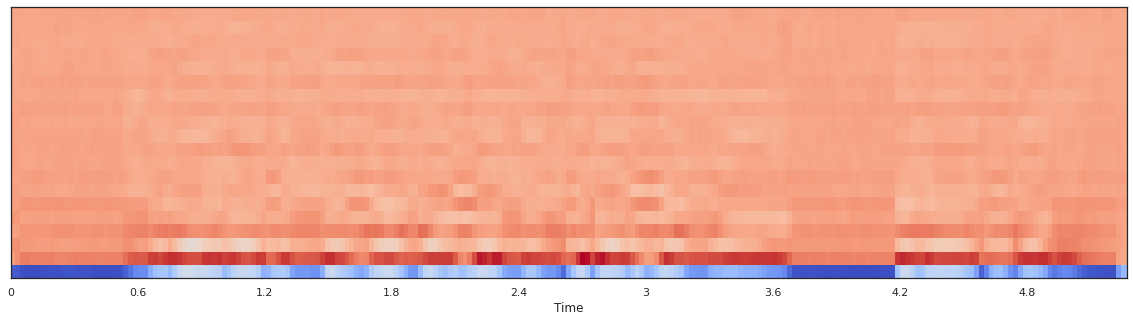

In [71]:
# MFCC
plt.figure(figsize=(20,5))
mfccs = librosa.feature.mfcc(samples, sr=sr)
print(mfccs.shape)

librosa.display.specshow(mfccs, sr=sr, x_axis='time')
plt.show()